In [3]:
import numpy as np
import importlib
import math
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R

In [4]:
P1 = np.array([[1,0,0,0.5],[0,1,0,-0.25],[0,0,1,0.3],[0,0,0,1]])
P2 = np.array([[1,0,0,-0.1],[0,1,0,0.4],[0,0,1,0.2],[0,0,0,1]])
P3 = np.array([[1,0,0,-0.7],[0,1,0,0],[0,0,1,0.4],[0,0,0,1]])

# Distance in meter
Dist_12 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P2[0,3],P2[1,3],P2[2,3]])),3)
Dist_13 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)
Dist_23 = round(np.linalg.norm(np.array([P2[0,3],P2[1,3],P2[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)
print(Dist_12)
print(Dist_13)
print(Dist_23)

0.89
1.23
0.748


In [86]:
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, math.cos(theta),-math.sin(theta)],
                   [ 0, math.sin(theta), math.cos(theta)]])
  
def Ry(theta):
  return np.matrix([[ math.cos(theta), 0, math.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-math.sin(theta), 0, math.cos(theta)]])
  
def Rz(theta):
  return np.matrix([[ math.cos(theta), -math.sin(theta), 0 ],
                   [ math.sin(theta), math.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

In [132]:
# Trajectories simulator (2D)
# Timestamps
begin = 0  #s
end = 40  #s               # Traj 1: 1000, Traj 2: 500
rate = 100    #Hz             # Traj 1: 20, Traj 2:100
#t = np.linspace(begin, end, (end-begin+1)*hz)
t = np.arange(begin, end, 1/rate)
xt = np.arange(len(t))

# Speed functions
# Traj 1
speed_linear = (np.cos(t+np.pi)+1)*2/2 
speed_yaw = np.sin(0.1*math.pi*t)/(5*math.pi)*np.cos(0.2*math.pi*t)

# Traj 2
xt = np.arange(len(t))
speed_linear = (np.cos(t+np.pi)+1)*2/2 
speed_yaw = np.sin(0.1*math.pi*t)/(15*math.pi)*np.cos(0.2*math.pi*t)

# Traj 3
xt = np.arange(len(t))
speed_linear = np.ones_like(xt)
speed_yaw = np.sin(0.9*math.pi*t)*0.05

# Traj 4
xt = np.arange(len(t))
speed_linear = np.ones_like(xt)
speed_yaw = np.sin(t)
speed_pitch = np.sin(t)
speed_roll = np.sin(t)*0

# Init 
T_2d = []
T_3d = []
yaw = []
pitch = []
roll = []
x = []
y = []
z = []
T_2d.append(np.array([[0, 0, 0],[0, 0, 0],[0,0,1]]))
T_3d.append(np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0,0,1,0],[0,0,0,1]]))
yaw.append(0)
pitch.append(0)
roll.append(0)
x.append(0)
y.append(0)
z.append(0)

for i in range(1, len(t)):
    # Update coordinates
    dx = speed_linear[i]*1/rate
    dy = 0
    dz = 0
    d_yaw = speed_yaw[i]*1/rate
    d_pitch = speed_pitch[i]*1/rate
    d_roll = speed_roll[i]*1/rate
    
    former_yaw = yaw[i-1]
    new_yaw = former_yaw + speed_yaw[i]*1/rate
    former_pitch = pitch[i-1]
    new_pitch = former_pitch + speed_pitch[i]*1/rate
    former_roll = roll[i-1]
    new_roll = former_roll + speed_roll[i]*1/rate
    
    # Compute new pose
    R_transition = np.array([[np.cos(d_yaw),-np.sin(d_yaw)],[np.sin(d_yaw),np.cos(d_yaw)]])
    Transition = np.array([x[i-1], y[i-1]])+ np.array([dx, dy])
    P_new = R_transition[0:2,0:2]@Transition
    R_new_2D = np.array([[np.cos(yaw),-np.sin(yaw)],[np.sin(yaw),np.cos(yaw)]])
    
    R_transition_3D = np.array(Rz(d_yaw)@Ry(d_pitch)@Rx(d_roll))
    Transition_3D = np.array([x[i-1], y[i-1], z[i-1]])+ np.array([dx, dy, dz])
    P_new_3D = R_transition_3D[0:3,0:3]@Transition_3D
    R_new_3D = Rz(new_yaw)@Ry(new_pitch)@Rx(new_roll)
    
    #T_new_2d = np.column_stack((R_new, P_new.T))
    #array_0 = np.array([[0,0,1]])
    #T_new_new_2d = np.concatenate((T_new_2d, array_0), axis=0)
    #T_2d.append(T_new_new_2d)
    
    # Add Z axis
    #P_3d = np.array([P_new[0], P_new[1], 0, 1])
    #array_1 = np.array([0,0])
    #array_2 = np.array([[0,0,1]])
    #array_3 = np.array([[0,0,0]])
    
    # 3D matrix
    #T_new_3d = np.column_stack((R_new, array_1.T))
    #T_new_new_3d = np.concatenate((T_new_3d, array_2, array_3), axis=0)
    #T_new_new_new_3d = np.column_stack((T_new_new_3d, P_3d.T))
    
    T_new_3d = np.column_stack((R_new_3D, P_new_3D.T))
    T_new_new_3d = np.concatenate((T_new_3d, np.array([[0,0, 0,1]])), axis=0)
    #T_new_new_new_3d = np.column_stack((T_new_new_3d, P_3d.T))
    
    # Save new 3D coordinates
    T_3d.append(T_new_new_3d)
    yaw.append(new_yaw)
    pitch.append(new_pitch)
    roll.append(new_roll)
    x.append(P_new_3D.flatten()[0])
    y.append(P_new_3D.flatten()[1])
    z.append(P_new_3D.flatten()[2])

<IPython.core.display.Javascript object>


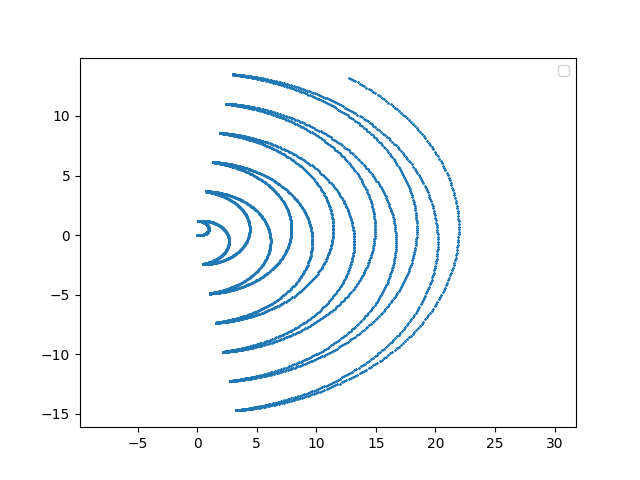

No handles with labels found to put in legend.


(-1.0977967102002666,
 23.053730914205598,
 -16.133234803939484,
 14.900558981772528)

In [133]:
%matplotlib notebook
#plt.plot(t, x, label="x")
#plt.plot(t, y, label="y")
T_arr = np.array(T_3d)
#print(T_arr[:,0,2])
plt.scatter(T_arr[:,0,3],T_arr[:,1,3], s=1, marker="*")
#plt.scatter(T_arr[:,0,3],T_arr[:,2,3], s=1, marker="*")
#plt.scatter(t,T_arr[:,2,3], s=1, marker="*")
#plt.plot(t,yaw)
#plt.plot(t,pitch)
#plt.plot(t,roll)
#plt.plot(t,speed_yaw)
#plt.plot(t,x)
#plt.plot(t,y)
plt.legend(loc='best')
plt.axis('equal')

4000


<IPython.core.display.Javascript object>


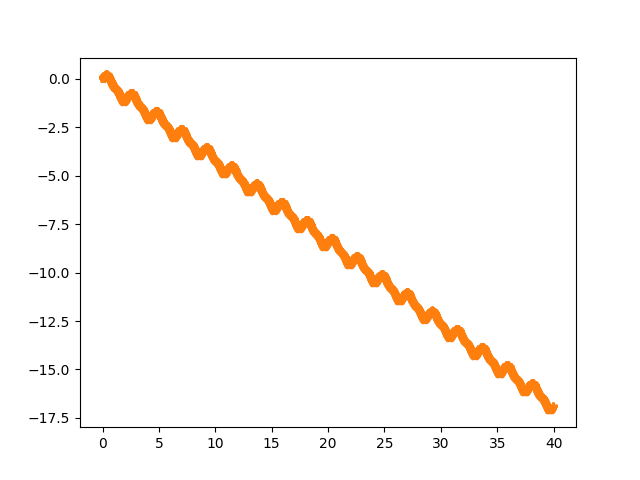

In [9]:
%matplotlib notebook
print(len(T_arr))
subsampling = 10
T_sub = []
t_sub = []
for i in range(0,len(T_arr)):
    if(i%subsampling==0):
        T_sub.append(T_arr[i])
        t_sub.append(t[i])
#plt.plot(t, x)
#plt.plot(t, y)
T_sub_arr = np.array(T_sub)
#print(T_arr[:,0,2])
#plt.scatter(T_sub_arr[:,0,3],T_sub_arr[:,1,3], s=1, marker="*")
plt.plot(t_sub,T_sub_arr[:,0,3], marker="*")
plt.plot(t,T_arr[:,0,3], marker="*")
#plt.plot(t,angle)
#plt.plot(t,x)
#plt.plot(t,y)

400
134
134
39.9


<IPython.core.display.Javascript object>


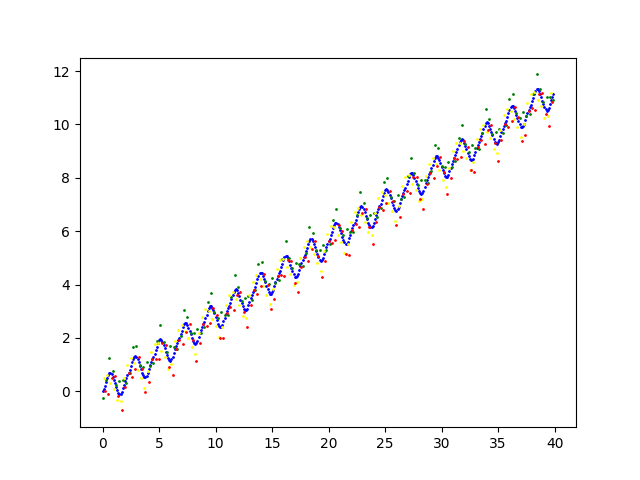

In [10]:
%matplotlib notebook
#print(np.array(T_3d[1000])@P1)
T_p1 = T_sub@P1
T_p2 = T_sub@P2
T_p3 = T_sub@P3

T_p1_ref = T_3d@P1
T_p2_ref = T_3d@P2
T_p3_ref = T_3d@P3

# Asynchronous data, 1 out 3
T_p1_3 = []
T_p2_3 = []
T_p3_3 = []
t_sub_1 = []
t_sub_2 = []
t_sub_3 = []
for i in range(0,len(T_sub)):
    if(i%3==0):
        T_p1_3.append(T_p1[i])
        t_sub_1.append(t_sub[i])
    if(i%3==1):
        T_p2_3.append(T_p2[i])
        t_sub_2.append(t_sub[i])
    if(i%3==2):
        T_p3_3.append(T_p3[i])
        t_sub_3.append(t_sub[i])
        
print(len(T_sub))
print(len(T_p1_3))
print(len(t_sub_1))
print(t_sub[-1]-t_sub[0])

T_1_arr = np.array(T_p1_3)
T_2_arr = np.array(T_p2_3)
T_3_arr = np.array(T_p3_3)

#plt.scatter(T_p1[:,0,3],T_p1[:,1,3], s=1)
#plt.scatter(T_p2[:,0,3],T_p2[:,1,3], s=1)
#plt.scatter(T_p3[:,0,3],T_p3[:,1,3], s=1)

plt.scatter(t_sub,T_sub_arr[:,1,3], s=1, color='b')
plt.scatter(t_sub_1,T_1_arr[:,1,3], s=1, color='g')
plt.scatter(t_sub_2,T_2_arr[:,1,3], s=1, color='yellow')
plt.scatter(t_sub_3,T_3_arr[:,1,3], s=1, color='r')

In [11]:
d12 = []
d13 = []
d23 = []
for i,j,k in zip(T_p1,T_p2,T_p3):
    p1 = np.array([i[0,3],i[1,3],i[2,3]])
    p2 = np.array([j[0,3],j[1,3],j[2,3]])
    p3 = np.array([k[0,3],k[1,3],k[2,3]])
    d12.append(round(np.linalg.norm(p1-p2),3))
    d13.append(round(np.linalg.norm(p1-p3),3))
    d23.append(round(np.linalg.norm(p2-p3),3))

<IPython.core.display.Javascript object>


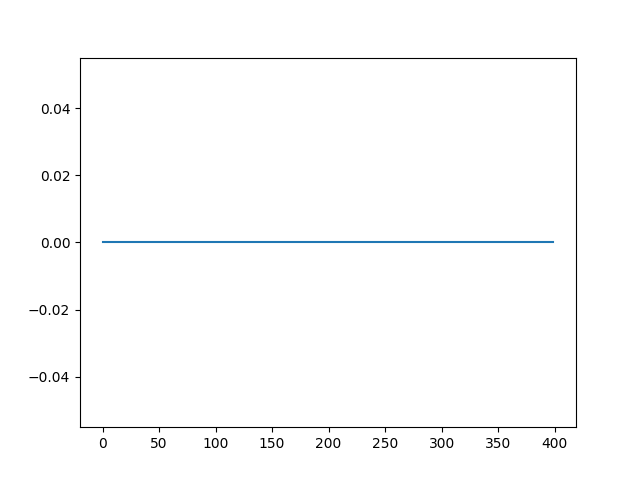

In [12]:
plt.plot(d13-Dist_13)

In [13]:
import scripts.theodolite_utils as tfu
tfu = importlib.reload(tfu)

tfu.Convert_data_to_csv(t_sub, T_p1[:,:,3], "./data/simulation/sub_traj_prism_1_3.csv")
tfu.Convert_data_to_csv(t_sub, T_p2[:,:,3], "./data/simulation/sub_traj_prism_2_3.csv")
tfu.Convert_data_to_csv(t_sub, T_p3[:,:,3], "./data/simulation/sub_traj_prism_3_3.csv")

Conversion done !
Conversion done !
Conversion done !


In [14]:
import scripts.theodolite_utils as tfu
tfu = importlib.reload(tfu)
tfu.Convert_data_to_csv(t_sub_1, T_1_arr[:,:,3], "./data/simulation/asy_traj_prism_1_3.csv")
tfu.Convert_data_to_csv(t_sub_2, T_2_arr[:,:,3], "./data/simulation/asy_traj_prism_2_3.csv")
tfu.Convert_data_to_csv(t_sub_3, T_3_arr[:,:,3], "./data/simulation/asy_traj_prism_3_3.csv")


Conversion done !
Conversion done !
Conversion done !


In [15]:
import scripts.theodolite_utils as tfu
tfu = importlib.reload(tfu)
tfu.Convert_data_to_csv(t, T_p1_ref[:,:,3], "./data/simulation/ref_traj_prism_1_3.csv")
tfu.Convert_data_to_csv(t, T_p2_ref[:,:,3], "./data/simulation/ref_traj_prism_2_3.csv")
tfu.Convert_data_to_csv(t, T_p3_ref[:,:,3], "./data/simulation/ref_traj_prism_3_3.csv")

Conversion done !
Conversion done !
Conversion done !


[0.00000000e+00 1.00025006e-02 2.00050013e-02 ... 3.99799950e+01
 3.99899975e+01 4.00000000e+01]
